In [10]:
import sys
import os
from os.path import dirname, basename,join, exists
import glob

# operations
import numpy as np
import pandas as pd
import geopandas as gpd
# import flopy

# plotting
# from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

from osgeo import gdal
import contextily as ctx



In [11]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [12]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
reload(flopy)

<module 'flopy' from 'C:\\Users\\ajcalder\\anaconda3\\envs\\geo_env\\Lib\\site-packages\\flopy\\__init__.py'>

In [13]:
def get_nodes(locs):
    ''' Converts layer, row, column into model node number '''
    nodes = []
    for k, i, j in locs:
        nodes.append(k * m.dis.nrow * m.dis.ncol + i * m.dis.ncol + j)
    return nodes


In [67]:
def epd_2_df(epd, rot = 0, crs=None):
    """ Provide an Endpoint recarray and rotation of grid (degrees) if one exists"""
    epd_df = pd.DataFrame().from_records(epd)
    # status meaning
    status_dict = {0:'Pending',1:'Active',2:'NormallyTerminated',3:'ZoneTerminated',4:'Unreleased',5:'Stranded'}
    epd_df['status_name'] = [status_dict.get(key) for key in epd_df.status]
    # return particle status
    print(str((epd_df.status==1).sum())+' particles still active. ')
    print(str((epd_df.status==5).sum()) +' particles stranded in dry cells')
    print(str((epd_df.status==2).sum())+' particles normally terminated')
    # present age in days
    epd_df['age_days'] = epd_df.time - epd_df.time0
    # age in years
    epd_df['age_years'] = epd_df.age_days/365
    if tracking == 'forward':
        loc_id = '' # with backward tracking final location is source
    elif tracking =='backward':
        loc_id = '0' # with forward tracking initial location is source
    # identify source row/column 
    epd_df['j'] = (epd_df['x'+loc_id]/delr-0.5).astype(int)
    epd_df['i'] = (epd_df['y'+loc_id]/delc-0.5).astype(int)
    # group by elevation rounded
    epd_df['elev_m'] = m.dis.top.array[epd_df.i.astype(int), epd_df.j.astype(int)]
    epd_df['elev_m_grp'] = ((epd_df['elev_m'] *0.5).round(-2))/0.5 # every 200 meters
    # summarize by modflow node
    epd_df_mean = epd_df.groupby('node'+loc_id).mean().reset_index()
    # convert the grid referenced x,y to a coordinate system referenced grid
    rot *= (np.pi/180) # convert degrees to radians
    lx = epd_df['x'+loc_id]
    ly = epd_df['y'+loc_id]
    x = lx*np.cos(rot) - ly*np.sin(rot)
    y = ly*np.cos(rot) + lx*np.sin(rot)
    epd_gdf = gpd.GeoDataFrame(epd_df, geometry = gpd.points_from_xy(x+xll, y+yll), crs=crs)
    lx = epd_df_mean['x'+loc_id]
    ly = epd_df_mean['y'+loc_id]
    x = lx*np.cos(rot) - ly*np.sin(rot)
    y = ly*np.cos(rot) + lx*np.sin(rot)
    epd_mean_gdf = gpd.GeoDataFrame(epd_df_mean, geometry = gpd.points_from_xy(x+xll, y+yll), crs=crs)

    return(epd_gdf, epd_mean_gdf)



In [15]:
def src_area_bnds(epd, aoi):
    if tracking == 'forward':
        loc_id = '0' # with forward tracking initial location is source
    elif tracking =='backward':
        loc_id = '' # with backward tracking final location is source
    from shapely.geometry import box
    outx = xll+epd['x'+loc_id]
    outy = yll+epd['y'+loc_id]
    src_box = box(outx.min(), outy.min(), outx.max() ,  outy.max())
    src_area = aoi[['Name','Hydrologic','geometry']].copy()
    src_area.geometry = [src_box]
    src_area.crs='epsg:3310'
    return(src_area)

In [5]:

loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
model_nam = 'inset_oneto_denier'

model_ws = loadpth+model_nam

m = flopy.modflow.Modflow.load('MF.nam', model_ws=model_ws, 
                                exe_name='mf-owhm', version='mfnwt') #, load_only = load_only)

nlay = m.dis.nlay
nrow = m.dis.nrow
ncol = m.dis.ncol
xll,yll = m.modelgrid.xoffset,m.modelgrid.yoffset

delr = m.dis.delr.array[0]
delc = m.dis.delc.array[0]

nper = m.dis.nper # number of months
perlen = m.dis.perlen.array # days per period

strt_date = np.datetime64(m.start_datetime)
end_date = strt_date + np.timedelta64(int(perlen.sum()-1),'D')

In [6]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
cbb = flopy.utils.CellBudgetFile(model_ws+'/MF.cbc')

times = hdobj.get_times()
# subtract 1 to have start of each period
dt_ref = pd.DataFrame(np.asarray(times), columns=['time']) 
dt_ref['timedelta'] = pd.to_timedelta(dt_ref.time, 'D').round('H')
dt_ref['dt'] = strt_date+dt_ref.timedelta
dt_ref['kstpkper'] = spd_stp
dt_ref[['kstp','kper']] = dt_ref.kstpkper.tolist()

In [48]:
# run shorter MODPATH simulation to reduce run time
n_days = (dt_ref.dt.max()-dt_ref.dt.min()).days # full time period

tracking = 'forward'
# tracking = 'backward'

mp_ws = join(model_ws,'mp',tracking, 'mp_'+str(n_days)+'days')
modelname = 'Modpath7'
print(basename(mp_ws))

mp_364days


In [37]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_nam,'rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

In [60]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
# get geodataframe for sfr
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1, sfrdf.j+1))]
grid_sfr = pd.concat((grid_sfr.reset_index(), sfrdf), axis=1)
# gdf for lak
lak_row, lak_col = np.where(m.lak.lakarr.array[0,0]>0)
grid_lak = grid_p.set_index(['row','column']).loc[list(zip(lak_row+1, lak_col+1))].reset_index()

In [16]:
# get nodes for Big Springs at the area of interest scale

aoi_arr = sfrdf[['k','i','j']]
aoi_arr = aoi_arr-1 # convert to 0 based
aoi_ids = list(zip(aoi_arr.k, aoi_arr.i, aoi_arr.j))

nodes_aoi = get_nodes(aoi_ids) # get nodes
print(len(nodes_aoi))

74


In [116]:
# p = flopy.utils.PathlineFile(mp_ws + modelname+'.mppth')
e = flopy.utils.EndpointFile(join(mp_ws, modelname + ".mpend"))

# big springs iso
# p_bs = p.get_destination_pathline_data(nodes_bs, to_recarray=True)
# p_bs = p.get_destination_pathline_data(nodes_bs_sfr, to_recarray=True)

# if tracking == 'forward':
#     epd_src = e.get_alldata() # returns the same result because backward tracking is a small initial area
# if tracking == 'backward':
#     epd_src = e.get_destination_endpoint_data(dest_cells=nodes_aoi)
# # epd_src = e.get_destination_endpoint_data(dest_cells=nodes_aoi, source=True)
    
epd_src = e.get_alldata() # returns the same result because backward tracking is a small initial area


In [124]:
(pd.DataFrame(epd_src).time - pd.DataFrame(epd_src).time0).unique()
# even releasing particles everywhere in the domain we see them all terminate immediately


array([0.0000000e+00, 2.3841858e-07, 7.6293945e-06], dtype=float32)

In [106]:
epd_gdf, epd_mean_gdf = epd_2_df(epd_src, rot=52.9, crs=grid_p.crs)

# bs_src_area = src_area_bnds(epd_src, bs_aoi)

0 particles still active. 
26499 particles stranded in dry cells
0 particles normally terminated


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_9724\69198164.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  epd_df_mean = epd_df.groupby('node'+loc_id).mean().reset_index()


In [114]:
# there is a small
# epd_gdf[epd_gdf.age_days>0].plot()

In [53]:
# epd_gdf.age_days.unique()

In [85]:
# particles instantly terminated
# even setting the start layer to 4 all of the particles instantly terminate, may be due to leakage face?
# layer 2 same issue so there is a problem with model set up
# before changing from stop_at to pass_through
# epd_gdf[['k0','xloc0','yloc0','k','xloc','yloc']]


<AxesSubplot: >

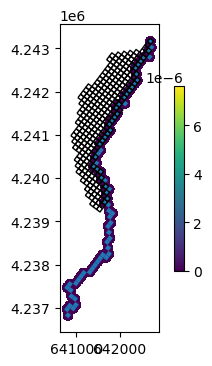

In [107]:
# most are weakly terminated
fig,ax = plt.subplots(figsize=(4,4))
epd_gdf.plot('age_days', ax=ax, legend=True, legend_kwds = {'shrink':0.6,'orientation':'vertical'})
grid_sfr.plot(ax=ax)
grid_lak.plot(ax=ax,color='none')

Initial forward tracking shows essentially all termination in zones ('weak sinks') and the map of the end points suggests very close points to the stream network from a top view. 

Plot a vertical slice to look at vertical pathways

In [33]:
t = flopy.utils.TimeseriesFile(mp_ws+ modelname + ".timeseries")

# file is 1.3 Gb
# ts = t.get_data() # loads nothing
ts = t.get_destination_timeseries_data(dest_cells=nodes_bs_aoi)
# create dataframe
ts_df = pd.DataFrame().from_records(ts)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/inset_oneto_denier\\mp\\forward\\mp_364daysModpath7.timeseries'

# Cumulative age plots

In [ ]:

# old code from shasta that needs to be updated
#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=len(epd_flow.date.unique()))

# plot a cumulative age plot for the cumulative three cells
# for each time step
fig,ax = plt.subplots(figsize=(6,6))
plt.cmap = 'gray'

for n, t in enumerate(epd_flow.date.unique()):
    t_epd = pd.DataFrame(epd_flow[epd_flow.date==t].copy())
    t_epd['weight'] = t_epd.flow/t_epd.flow.sum()
    t_epd = t_epd.sort_values('age_years')
    t_epd['weight_cum'] = t_epd.weight.cumsum()

    t_epd.plot(x='age_years',y='weight_cum', ax=ax,  label=str(t), color=cm.gray(norm(n)))
ax.set_xlabel('Age (years)')
ax.set_xscale('log') 
ax.set_ylabel('Flow Weighted Fraction of Particles')
ax.set_title('Cumulative Age Distribution\nby Stress Period')


custom_lines = [Line2D([0], [0], color=cm.gray(norm(0)), lw=4),
                Line2D([0], [0], color=cm.gray(norm(n)), lw=4)]
ax.legend(custom_lines, [epd_dates[0], epd_dates[n]], facecolor='lightgray', framealpha=1)

# plt.savefig(fig_dir+'/'+tracking+'/big springs cumulative age average' +  mp_info['strt_date'].values[0]+ '.png',
#             dpi=300, bbox_inches='tight')